In [2]:
# Open up dataset

In [3]:
# ! cp -r /storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES /home/hice1/hsuh45/scratch

^C


In [2]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Minimal Setup

'''
1. Load dataset, split evenly (reduce class / label imbalance), split to train/valid/test
2. Load pretrained model, edit it to fit our task
3. Loss (weighted CE or focal loss), eval metric (class-wise F1)

'''

'\n1. Load dataset, split evenly (reduce class / label imbalance), split to train/valid/test\n2. Load pretrained model, edit it to fit our task\n3. Loss (weighted CE or focal loss), eval metric (class-wise F1)\n\n'

In [4]:
data = pd.read_csv('~/scratch/OLIVES/OLIVES/Biomarker_Clinical_Data_Images_Updated.csv')
data
# data['Path (Trial/Arm/Folder/Visit/Eye/Image Name)']
data.columns

# Biomarkers labeled: (based on paper)
# IRHRF, FAVF, IRF, DRT/ME PAVF, VD,
# Preretinal Tissue, EZ Disruption, IR Hemmorhages,
# SRF, VMT, Atrophy, SHRM, RPE Disruption,
# Serous PED
bio_markers = data[data.columns[2:18]].values
bio_markers.shape
data.columns

Index(['Path (Trial/Arm/Folder/Visit/Eye/Image Name)', 'Scan (n/49)',
       'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL',
       'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face',
       'Fully attached vitreous face', 'Preretinal tissue/hemorrhage',
       'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)',
       'Disruption of RPE', 'PED (serous)', 'SHRM', 'Eye_ID', 'BCVA', 'CST',
       'Patient_ID'],
      dtype='object')

In [ ]:
# Dataset Load and split

# 96 eyes, 49 OCT images, 2 visits, 16 biomarkers (binary)
# 96 eyes, 49 OCT images, 2 visits, 496 x 504 OCT images (grayscale)

csv_file = '~/scratch/OLIVES/OLIVES/Biomarker_Clinical_Data_Images_Updated.csv'
data = pd.read_csv(csv_file)
col_names = data.columns
file_paths = data['Path (Trial/Arm/Folder/Visit/Eye/Image Name)'].values
scan_N = 9408
oct_N = 49
eye_N = 96
bio_markers = data[col_names[2:18]].values
bio_markers = bio_markers.reshape([eye_N*2*oct_N,-1])
clin_data = data[col_names[19:21]].values
clin_data = clin_data.reshape([eye_N*2*oct_N,-1])



home_dir = '/home/hice1/hsuh45/scratch/OLIVES/OLIVES/'
img = Image.open(home_dir + file_paths[0]).convert('L')
img_array = np.array(img)
sh = img_array.shape # Shape: [496, 504]
print('img_array shape: ',sh)

oct_img = np.zeros([eye_N*2*oct_N,sh[0],sh[1]], dtype=np.float32)

for i in range(len(file_paths)):
    try: 
        img = Image.open(home_dir + file_paths[i]).convert('L')
        img_array = np.array(img)
        oct_img[i] = img_array
        if(img_array.shape!=sh):
            print(f'diff shape {sh} vs {img_array.shape}')
        if (i%500==0):
            print('Saving ',i)
    except Exception as e:
        print(f"Error reading file {path}: {e}")
        
dataset = {
    'img': oct_img, # [eye_N,2,oct_N, height, width]
    'bio': bio_markers, #[eye_N,2,oct_N,16]
    'clin': clin_data #[eye_N, 2, oct_N, 2]
}



img_array shape:  (496, 504)
Saving  0
Saving  500
Saving  1000
Saving  1500
Saving  2000
Saving  2500
Saving  3000
Saving  3500


In [ ]:
# save dataset for later use 
import pickle
def save_dataset(dataset, filename="~/scratch/dataset.pkl"):
    with open(filename, 'wb') as file:
        pickle.dump(dataset, file)
    print(f"Dataset saved to {filename}")

save_dataset(dataset, filename="dataset.pkl")

def load_dataset(filename="dataset.pkl"):
    with open(filename, 'rb') as file:
        dataset = pickle.load(file)
    print(f"Dataset loaded from {filename}")
    return dataset

# loaded_dataset = load_dataset(filename="dataset.pkl")


In [8]:
# pip install scikit-multilearn


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


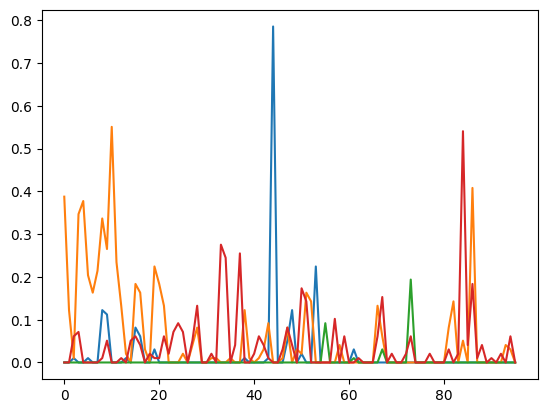

In [13]:
# Stratification
import matplotlib.pyplot as plt

# dist = np.mean(dataset['bio'],axis=(1,2))
# plt.plot(dist[:,0])
# plt.plot(dist[:,1])
# plt.plot(dist[:,2])
# plt.plot(dist[:,3])

In [16]:
from skmultilearn.model_selection import iterative_train_test_split

def multi_label_stratified_split(images, labels, test_size=0.2, val_size=0.1, random_state=42):
    """
    Splits the dataset into train, validation, and test sets using multi-label stratification.

    Args:
        images (np.ndarray): OCT images of shape [eye_N, visit_N, oct_scanN, H, W].
        labels (np.ndarray): Biomarker labels of shape [eye_N, visit_N, oct_scanN, bio_marker_N].
        test_size (float): Proportion of data for the test set.
        val_size (float): Proportion of data for the validation set (from remaining train set).
        random_state (int): Random seed for reproducibility.

    Returns:
        train_data, val_data, test_data: Tuples containing (images, labels) for each split.
    """
    np.random.seed(random_state)

    # Flatten visits and scans for eye-level data
    eye_labels = labels.any(axis=(1, 2))  # Shape: [eye_N, bio_marker_N]
    eye_images = images  # Shape remains [eye_N, visit_N, oct_scanN, H, W]

    # Split into train and test using multi-label stratification
    train_images, test_images, train_labels, test_labels = iterative_train_test_split(
        eye_images, eye_labels.astype(int), test_size=test_size
    )

    # Further split the train set into train and validation
    train_images, val_images, train_labels, val_labels = iterative_train_test_split(
        train_images, train_labels, test_size=val_size / (1 - test_size)
    )

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

# images = dataset['img']
# labels = dataset['bio']

# # Step 1: Multi-label stratified split
# train_data, val_data, test_data = multi_label_stratified_split(images, labels)


In [3]:
# from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

# DeiT preprocessing
transform_deit = transforms.Compose([
    transforms.Resize((512,512)),                # Resize to square dimensions
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize (adjust mean/std for grayscale)
])
# SwinT preprocessing
transform_swin = transforms.Compose([
    transforms.Resize((496,504)),                # Minimal resizing
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize (adjust mean/std for grayscale)
])


# Create DataLoaders with the preprocessed data
class OCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        img = self.images[index]  # Shape: [sample N, H, W]
        label = self.labels[index]  # Shape: [sample N, bio_marker_N]
        
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        return img, label

images = dataset['img']
labels = dataset['bio']

X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size = 0.2,
    random_state = 42
)
    
train_dataset = OCTDataset(X_train, y_train, transform=transform_deit)
# val_dataset = OCTDataset(val_data[0], val_data[1], preprocess_fn)
test_dataset = OCTDataset(X_test, y_test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


NameError: name 'dataset' is not defined